In [1]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2




# local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
import training

In [2]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 


# Model parameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE =  1500
TARGET_UPDATE = 10 #episodes
DEVICE = 'cuda:0'
MEMORY_CAPACITY = 12000

# agent = model.DoubleDQNAgent(imsize=IMSIZE, 
#                  in_channels=STACK_SIZE,
#                  n_actions=N_ACTIONS,
#                  memory_capacity=MEMORY_CAPACITY,
#                  eps_start=EPS_START,
#                  eps_end=EPS_END,
#                  eps_delta=EPS_DECAY,
#                  gamma_discount = GAMMA,
#                  batch_size = BATCH_SIZE,
#                  device=DEVICE)


# Optimizer Parameters
LR_DQN = 0.01

# optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

In [3]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)



In [4]:
## Training parameters 
MAX_EPISODES = 500 # number of episodes (an episode ends after agent hits a box)
MAX_STEPS  = 5e4  # number of optimization steps (each time step the model parameters are updated)
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Training configuration dictionary
cfg = dict()
# cfg['seed']                     = SEED
# cfg['training_condition']       = TRAINING_CONDITION 
cfg['max_episodes']             = MAX_EPISODES
# cfg['model_path']               = MODEL_PATH
cfg['max_steps']                = MAX_STEPS
cfg['target_update']            = TARGET_UPDATE
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL
cfg['replay_start_size']        = REPLAY_START_SIZE
# cfg['logfile']                  = LOGFILE

for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
   
            
        
            # Condition-specific configuration
            cfg['training_condition'] = 0 if complexity == 'plain' else 1 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            cfg['seed'] = seed
            torch.manual_seed(seed)
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity,phosphene_resolution,seed)
            print(model_name)
            cfg['logfile'] = 'Out/Exp1/{}_train_stats.csv'.format(model_name)
            cfg['model_path'] = 'Out/Exp1/{}_best_model.pth'.format(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 memory_capacity=MEMORY_CAPACITY,
                 eps_start=EPS_START,
                 eps_end=EPS_END,
                 eps_delta=EPS_DECAY,
                 gamma_discount = GAMMA,
                 batch_size = BATCH_SIZE,
                 device=DEVICE)

            optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

            # Start training
            training.train(agent, environment, img_processing, optimizer, cfg)
            print('finished training')

exp1_plain_phosNone_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 520
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 218 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 1904
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target 

step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 520
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 247 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 2224
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 201 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 1742
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episo

episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 131 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 1155
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 135 wall_collisions: 0, box_collisions: 4, endless_loops: 1, total_reward: 1126
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 177 wall_collisions: 0, box_collisions: 3, endless_loops: 1, total_reward: 1565
new best model
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 301 wall_collisions: 0, box_collisions: 2, endless_loops: 1, total_reward: 267

episode 190, target net updated
step count 175 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 1548
new best model
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 327 wall_collisions: 0, box_collisions: 3, endless_loops: 1, total_reward: 2867
new best model
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 276 wall_collisions: 0, box_collisions: 2, endless_loops: 2, total_reward: 2409
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 391 wall_collisions: 0, box_collisions: 2, endless_loops: 1, total_reward: 3460
new best model
episode 350, target net updated
episode 360, target net updated
episode 370, ta

episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 474 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 4320
new best model
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 451 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 4123
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 437 wall_collisions: 0, box_collisions: 1, endless_loops: 1, total_reward: 3895
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 440 wall_collisions: 0, box_collisions: 2, endless_loops: 0, total_reward: 3873
episode 450, 

episode 340, target net updated
step count 329 wall_collisions: 0, box_collisions: 2, endless_loops: 1, total_reward: 2862
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 374 wall_collisions: 0, box_collisions: 3, endless_loops: 0, total_reward: 3370
new best model
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 392 wall_collisions: 0, box_collisions: 1, endless_loops: 2, total_reward: 3390
new best model
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
finished training
exp1_plain_phos34_S1
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 0, target net updated
episode 10, target net up

episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 303 wall_collisions: 0, box_collisions: 1, endless_loops: 2, total_reward: 2643
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
finished training
exp1_plain_phos34_S4
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 520
new best model
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 520
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_rew

finished training
exp1_plain_phos26_S2
step count 57 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 437
new best model
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 520
new best model
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 520
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 145 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 1229
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net u

step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 520
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 62 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 520
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 174 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 1464
new best model
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode

episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 190 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 1753
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 228 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 2111
new best model
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 156 wall_collisions: 0, box_collisions: 4, endless_loops: 1, total_reward: 1325
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 182 wall_collisions: 0, box_collisions: 3, endless_loops: 2, total_reward: 153

episode 190, target net updated
step count 93 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 797
new best model
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 171 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 1552
new best model
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 165 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 1429
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 375 wall_collisions: 0, box_collisions: 2, endless_loops: 0, total_reward: 3366
new best model
episode 350, target net updated
episode 360, target net updated
episode 370, targ

episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 195 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 1704
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 195 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 1704
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 259 wall_collisions: 0, box_collisions: 4, endless_loops: 1, total_reward: 2234
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 210 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 1865
episode 450, target net upda

In [5]:
# EXAMPLES = 10

# i = 0
# bad_choices = [(state, action, next_state,reward) for (state, action, next_state,reward) in agent.memory.memory if reward<0 and action ==0]
# # for state, action, next_state, reward in agent.memory.memory[:EXAMPLES]:
# for state, action, next_state, reward in bad_choices[:EXAMPLES]:
#     i+=1
    
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward.item()))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
    
# # plt.tight_layout()


## Validation:

In [1]:
import torch
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns

# # local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
from testing import test

#### Run models on test environment:

In [2]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)
    
img_processing = ImageProcessor

In [3]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 128 #original 128
DEVICE = 'cuda:0'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

test_data = []
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
            
            # Condition-specific configuration
            cfg['training_condition']       = 2 if complexity == 'plain' else 3 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            model_path = 'Out/Exp1/{}_best_model.pth'.format(model_name)
            print(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)
            agent.policy_net.load_state_dict(torch.load(model_path))

            # Testing
            conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed}
            results = test(agent, environment, img_processing, cfg)
            test_data.append({**conditions,**results})
data = pd.DataFrame(test_data)
data.to_csv('Out/Exp1/_test_results.csv', ignore_index=True)

exp1_plain_phosNone_S0


NameError: name 'utils' is not defined

In [6]:
OUTDIR = 'Out/Exp1'
files  = os.listdir(OUTDIR)

all_stats = sorted([os.path.join(OUTDIR,f) for f in files if 'train_stats.csv' in f])

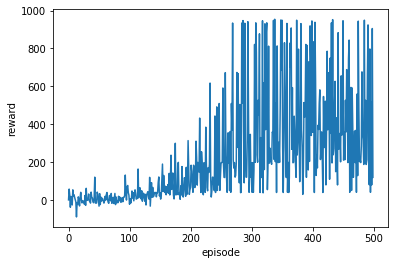

In [53]:
stats = pd.read_csv(all_stats[50])
sns.lineplot(data=stats.loc[stats.validation==0], x='episode',y='reward')

In [60]:
stats

,episode,step_count,wall_collisions,box_collisions,endless_loops,reward,train_loss,validation
0,0,25,25,0,5,-255.0,0.000000,1
1,0,0,0,0,0,0.0,0.000000,0
2,1,35,6,1,0,57.0,0.000000,0
3,2,13,1,1,0,25.0,0.000000,0
4,3,18,6,0,1,-39.0,0.000000,0
...,...,...,...,...,...,...,...,...
505,495,7,0,1,0,40.0,3755.094235,0
506,496,67,1,0,1,518.0,3760.917182,0
507,497,12,0,1,0,79.0,3761.693332,0
508,498,115,4,0,0,905.0,3770.297143,0


In [34]:
for f in all_stats:
    stats = pd.read_csv(f)
    max_reward = stats.reward.max()
    print('{} : {}'.format(f,max_reward))

Out/Exp1/exp1_complex_phos10_S0_train_stats.csv : 3000.0
Out/Exp1/exp1_complex_phos10_S1_train_stats.csv : 1585.0
Out/Exp1/exp1_complex_phos10_S2_train_stats.csv : 3049.0
Out/Exp1/exp1_complex_phos10_S3_train_stats.csv : 1712.0
Out/Exp1/exp1_complex_phos10_S4_train_stats.csv : 2763.0
Out/Exp1/exp1_complex_phos18_S0_train_stats.csv : 2527.0
Out/Exp1/exp1_complex_phos18_S1_train_stats.csv : 2812.0
Out/Exp1/exp1_complex_phos18_S2_train_stats.csv : 2827.0
Out/Exp1/exp1_complex_phos18_S3_train_stats.csv : 2877.0
Out/Exp1/exp1_complex_phos18_S4_train_stats.csv : 2019.0
Out/Exp1/exp1_complex_phos26_S0_train_stats.csv : 2898.0
Out/Exp1/exp1_complex_phos26_S1_train_stats.csv : 3709.0
Out/Exp1/exp1_complex_phos26_S2_train_stats.csv : 2414.0
Out/Exp1/exp1_complex_phos26_S3_train_stats.csv : 2491.0
Out/Exp1/exp1_complex_phos26_S4_train_stats.csv : 2287.0
Out/Exp1/exp1_complex_phos34_S0_train_stats.csv : 3279.0
Out/Exp1/exp1_complex_phos34_S1_train_stats.csv : 2919.0
Out/Exp1/exp1_complex_phos34_S2

In [62]:
results = pd.DataFrame(columns = ['complexity', 'resolution', 'seed', 'val_reward','val_collisions'])
for c in ['plain','complex']:
    for r in [10,18,26,34,42,50,'None']:
        for s in range(5):
            fn = 'Out/Exp1/exp1_{}_phos{}_S{}_train_stats.csv'.format(c,r,s)
            stats = pd.read_csv(fn)
            idx = stats.reward.idxmax()
            val_reward = stats.reward[idx]
            val_collisions = stats.box_collisions[idx] + stats.wall_collisions[idx]
            results = results.append({'complexity' : c,
                           'resolution' : r, 
                           'seed' : s, 
                           'val_reward' : val_reward,
                           'val_collisions' : val_collisions,},ignore_index=True)

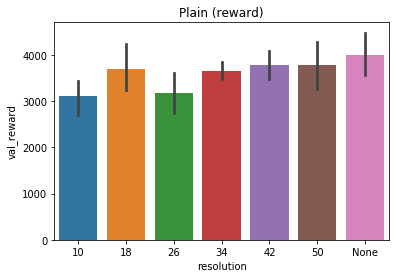

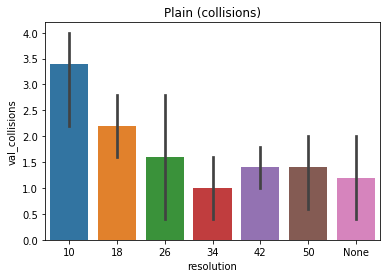

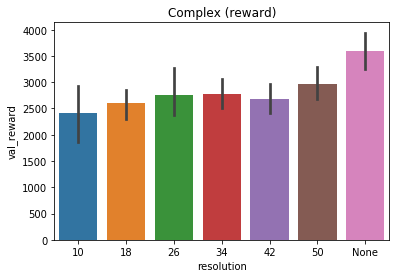

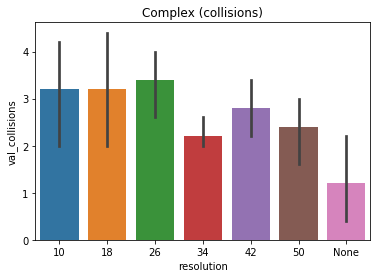

In [68]:
sns.barplot(data=results.loc[results.complexity == 'plain'],y = 'val_reward', x='resolution')
plt.title('Plain (reward)')
plt.show()
sns.barplot(data=results.loc[results.complexity == 'plain'],y = 'val_collisions', x='resolution')
plt.title('Plain (collisions)')
plt.show()
sns.barplot(data=results.loc[results.complexity == 'complex'],y = 'val_reward', x='resolution')
plt.title('Complex (reward)')
plt.show()
sns.barplot(data=results.loc[results.complexity == 'complex'],y = 'val_collisions', x='resolution')
plt.title('Complex (collisions)')
plt.show()